In [1]:
import autograd.numpy as np
import matplotlib.pyplot as plt
from autograd import grad, elementwise_grad, hessian, jacobian

import sys
sys.path.insert(0, "../../project_2/src")
from SGD import minibatch

In [2]:
# Inspired by mortens example code in week 43

def activation_function(z):
    return np.maximum(0, z)

def activation_out(z):
    return z

"""
network_shape = [inputs, w1, w2, ..., wL, outputs]

W = wwwwb
    wwwwb
"""
def initialize_params(network_shape):
    P = []
    for i in range(1, len(network_shape)):
        k = network_shape[i-1]
        j = network_shape[i]
        P.append(np.random.randn(j, k) * np.sqrt(2) / np.sqrt(k))
        P[i-1] = np.concatenate((P[i-1], np.zeros(j).reshape(-1,1)), axis=1)

    return P

def Network(x, P):
    # Assume always one point input at a time. Note the [0][0] is to ensure the output to
    # the jacobian and hessians is scalar. Have a separate function for predictions after training
    a = x.reshape(1,-1)
    for P_i in P:
        #a = np.concatenate((a, np.ones(np.size(a, 0)).reshape(-1, 1)), axis=1) 
        a = np.concatenate((a, np.ones((1,1))), axis=1) 
        z = np.matmul(a, np.transpose(P_i))
        a = activation_function(z)
    
    return activation_out(z)[0][0]

def Network_predict(x, P):
    #This is for predictions after training, where we can pass the whole x-matrix in one go.
    a = x
    for P_i in P:
        a = np.concatenate((a, np.ones(np.size(a, 0)).reshape(-1, 1)), axis=1) 
        z = np.matmul(a, np.transpose(P_i))
        a = activation_function(z)
    
    return activation_out(z)

def optimize(X, P, N_minibatches, learning_rate, n_epochs):
    
    assert N_minibatches <= np.size(X, 0)

    cost_func_grad = grad(costfunction, 1)
    
    for epoch in range(n_epochs):
        mb = minibatch(X, N_minibatches)
        for i in range(N_minibatches):
            X_mb = X[mb[i]]
            M = np.size(X_mb, 0)
            # compute gradients of weights
            cost_grad = cost_func_grad(X_mb, P)
            for l in range(len(P)):
                P[l] -= learning_rate * cost_grad[l]
    return P

def g_trial(x, P):
    return (1 - x[1]) * np.sin(np.pi * x[0]) + x[0] * (1 - x[0]) * x[1] * Network(x, P)

def g_trial_predict(x, P):
    # Note that the reshaping of the network ouput is necessary to ensure compatible shape with the x-slicing.
    # The output is of shape (len_x * len_t,)
    return (1 - x[:,1]) * np.sin(np.pi * x[:,0]) + x[:,0] * (1 - x[:,0]) * x[:,1] * Network_predict(x, P).reshape(-1)

def costfunction(x, P):
    cost = 0
    u_hess = hessian(g_trial)
    u_jacob = jacobian(g_trial)
    
    for point in x:
        dudx2 = u_hess(point, P)[0,0]
        dudt = u_jacob(point, P)[1]
        #cost += (dudt - dudx2)**2 #Autograd recommend using cost = cost +, instead.
        cost = cost + (dudt - dudx2)**2

    return cost / np.size(x, 0)

In [3]:
x = np.linspace(0,1,10)
t = np.linspace(0,1,10)
x, t = np.meshgrid(x, t) 
x = x.flatten()
t = t.flatten()
X = np.concatenate((x.reshape(-1,1), t.reshape(-1, 1)), axis=1)

network_shape = [np.size(X, 1), 10, 1]
P = initialize_params(network_shape)

In [4]:
P = optimize(X, P, 10, 0.002, 10)
#y = Network(X[0, :].reshape(1, 2), P)

Text(0, 0.5, '$t$')

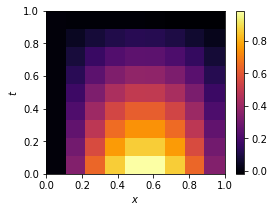

In [5]:
x = np.linspace(0,1,10) # make last argument variable
t = np.linspace(0,1,10)
x_plot, t_plot = np.meshgrid(x, t)
x = x_plot.flatten()
t = t_plot.flatten()
X = np.concatenate((x.reshape(-1,1), t.reshape(-1, 1)), axis=1)

Z = g_trial_predict(X,P)
Z = Z.reshape(10,10) # make arguments variable.

fig, ax = plt.subplots(figsize=(4, 3))
cf = ax.pcolormesh(x_plot, t_plot, Z, cmap=plt.get_cmap("inferno"))
fig.colorbar(cf, ax=ax)
ax.set_xlabel("$x$")
ax.set_ylabel("$t$")